In [1]:
from pathlib import Path

from bertviz import head_view

import torch

In [2]:
from model.swan import SWANPhase1Only
from model.base import chkpt
from test_model import load_config, run_model_for_attention
from common.dataset import Dataset
from learner import *

In [3]:
main_path = Path('.')
data_path = main_path / 'resource'
chpt_path = main_path / 'runs_copy' / 'best_SWAN_P1'

In [4]:
tokenizer = torch.load(chpt_path / 'tokenizer.pt')
checkpoint = torch.load(chpt_path / 'SWANPhase1Only.pt')

In [5]:
config = load_config(chpt_path)
nvix = SWANPhase1Only.create_or_load(path=str(chpt_path), **config)
nvix.eval()

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predi

SWANPhase1Only(
  (encoder): TextEncoder(
    (model): ElectraModel(
      (embeddings): ElectraEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): ElectraEncoder(
        (layer): ModuleList(
          (0): ElectraLayer(
            (attention): ElectraAttention(
              (self): ElectraSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): ElectraSelfOutput(
                (dense): Linear(in_features=768, out_features=768, b

In [6]:
state_dict = nvix.state_dict()

In [7]:
dataset_file = data_path / 'dataset' / 'pen.json'
test_data = Dataset(dataset_file, number_window=3)

In [8]:
SPLIT = 'test'
test_data.select_items_with_file(data_path / 'experiments'/ 'pen' / SPLIT)

In [9]:
test_data.num_items

365

In [10]:
# 'sears tower' problem index: 49th of 'dev'

PROB_IDX = 0

set_seed(config['seed'])
batch = test_data.get_minibatches(batch_size=1, for_testing=True)
output = nvix(
    text=batch[PROB_IDX].text.to(nvix.device),
    beam=3,
    beam_expl=1
)

[W Context.cpp:70] Warning: torch.use_deterministic_algorithms is in beta, and its design and functionality may change in the future. (function operator())


In [11]:
a = nvix.attention_scores 
a.shape

torch.Size([26, 1, 18])

In [12]:
batch[PROB_IDX].text.as_dict()['raw'][0]

'jeremy strolled 20 kilometers at 2 kilometers per hour . how long did jeremy stroll ?'

In [13]:
batch[PROB_IDX].text.as_dict()['tokens'].shape

torch.Size([1, 18])

In [14]:
output

{'eqn_ignore': {1},
 'var_expl': [Label([[102, 1996, 3091, 1997, 2051, 1997, 27244, 2075, 102]])],
 'num_expl': [Label([[102, 1996, 3292, 1997, 27244, 2075, 1999, 7338, 102, -1, -1], [102, 1996, 3177, 1997, 27244, 2075, 1999, 7338, 2566, 3178, 102]])],
 'explanation': [Explanation(numbers=$[Label([[102, 1996, 3292, 1997, 27244, 2075, 1999, 7338, 102, -1, -1], [102, 1996, 3177, 1997, 27244, 2075, 1999, 7338, 2566, 3178, 102]])], variables=$[Label([[102, 1996, 3091, 1997, 2051, 1997, 27244, 2075, 102]])], worker=$0)],
 'equation': Equation(operator=Label([[0]]), operands=[Label([[-1]]), Label([[-1]])])}

In [15]:
output['explanation'][0].to_human_readable(tokenizer=tokenizer)

defaultdict(list,
            {'N_00': ['the distance of strolling in kilometers'],
             'N_01': ['the speed of strolling in kilometers per hour'],
             'X_00': ['the length of time of strolling']})

In [16]:
from typing import List, Dict

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence: List[str], explanation: Dict[str, List[str]], attention: torch.Tensor, n_cols=1):
    n_rows = len(explanation)
    assert n_rows * n_cols == len(explanation)

    # Get the longest explanation length: attention weights will be divided according to this length
    # max_attn_len = 0
    # for k in explanation:
    #     expl_len = len(explanation[k][0].split()) + 2
    #     if max_attn_len < expl_len:
    #         max_attn_len = expl_len
    # print(max_attn_len)

    _attention = attention.exp().squeeze()

    fig = plt.figure(figsize=(40, 40))

    begin_idx = 0
    end_idx = 0
    for i, k in enumerate(explanation):
        expl_list = explanation[k][0].split()+['<EOS>']
        end_idx = begin_idx + len(expl_list)
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)

        _attn_for_expl = _attention[begin_idx:end_idx]
        _attn_for_expl = _attn_for_expl.numpy()

        cax = ax.matshow(_attn_for_expl, cmap='bone')
        fig.colorbar(cax)

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<SOS>']+[t for t in sentence]+['<EOS>'], 
                           rotation=45)
        ax.set_yticklabels(['']+expl_list)
        ax.set_title(k)
        ax.set_xlabel('Source Sentence')
        ax.xaxis.set_label_position('top')
        ax.set_ylabel(f'Explanation for {k}')

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        begin_idx = end_idx

    plt.show()
    plt.close()

/tmp/ipykernel_1154727/257429340.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<SOS>']+[t for t in sentence]+['<EOS>'],
/tmp/ipykernel_1154727/257429340.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+expl_list)


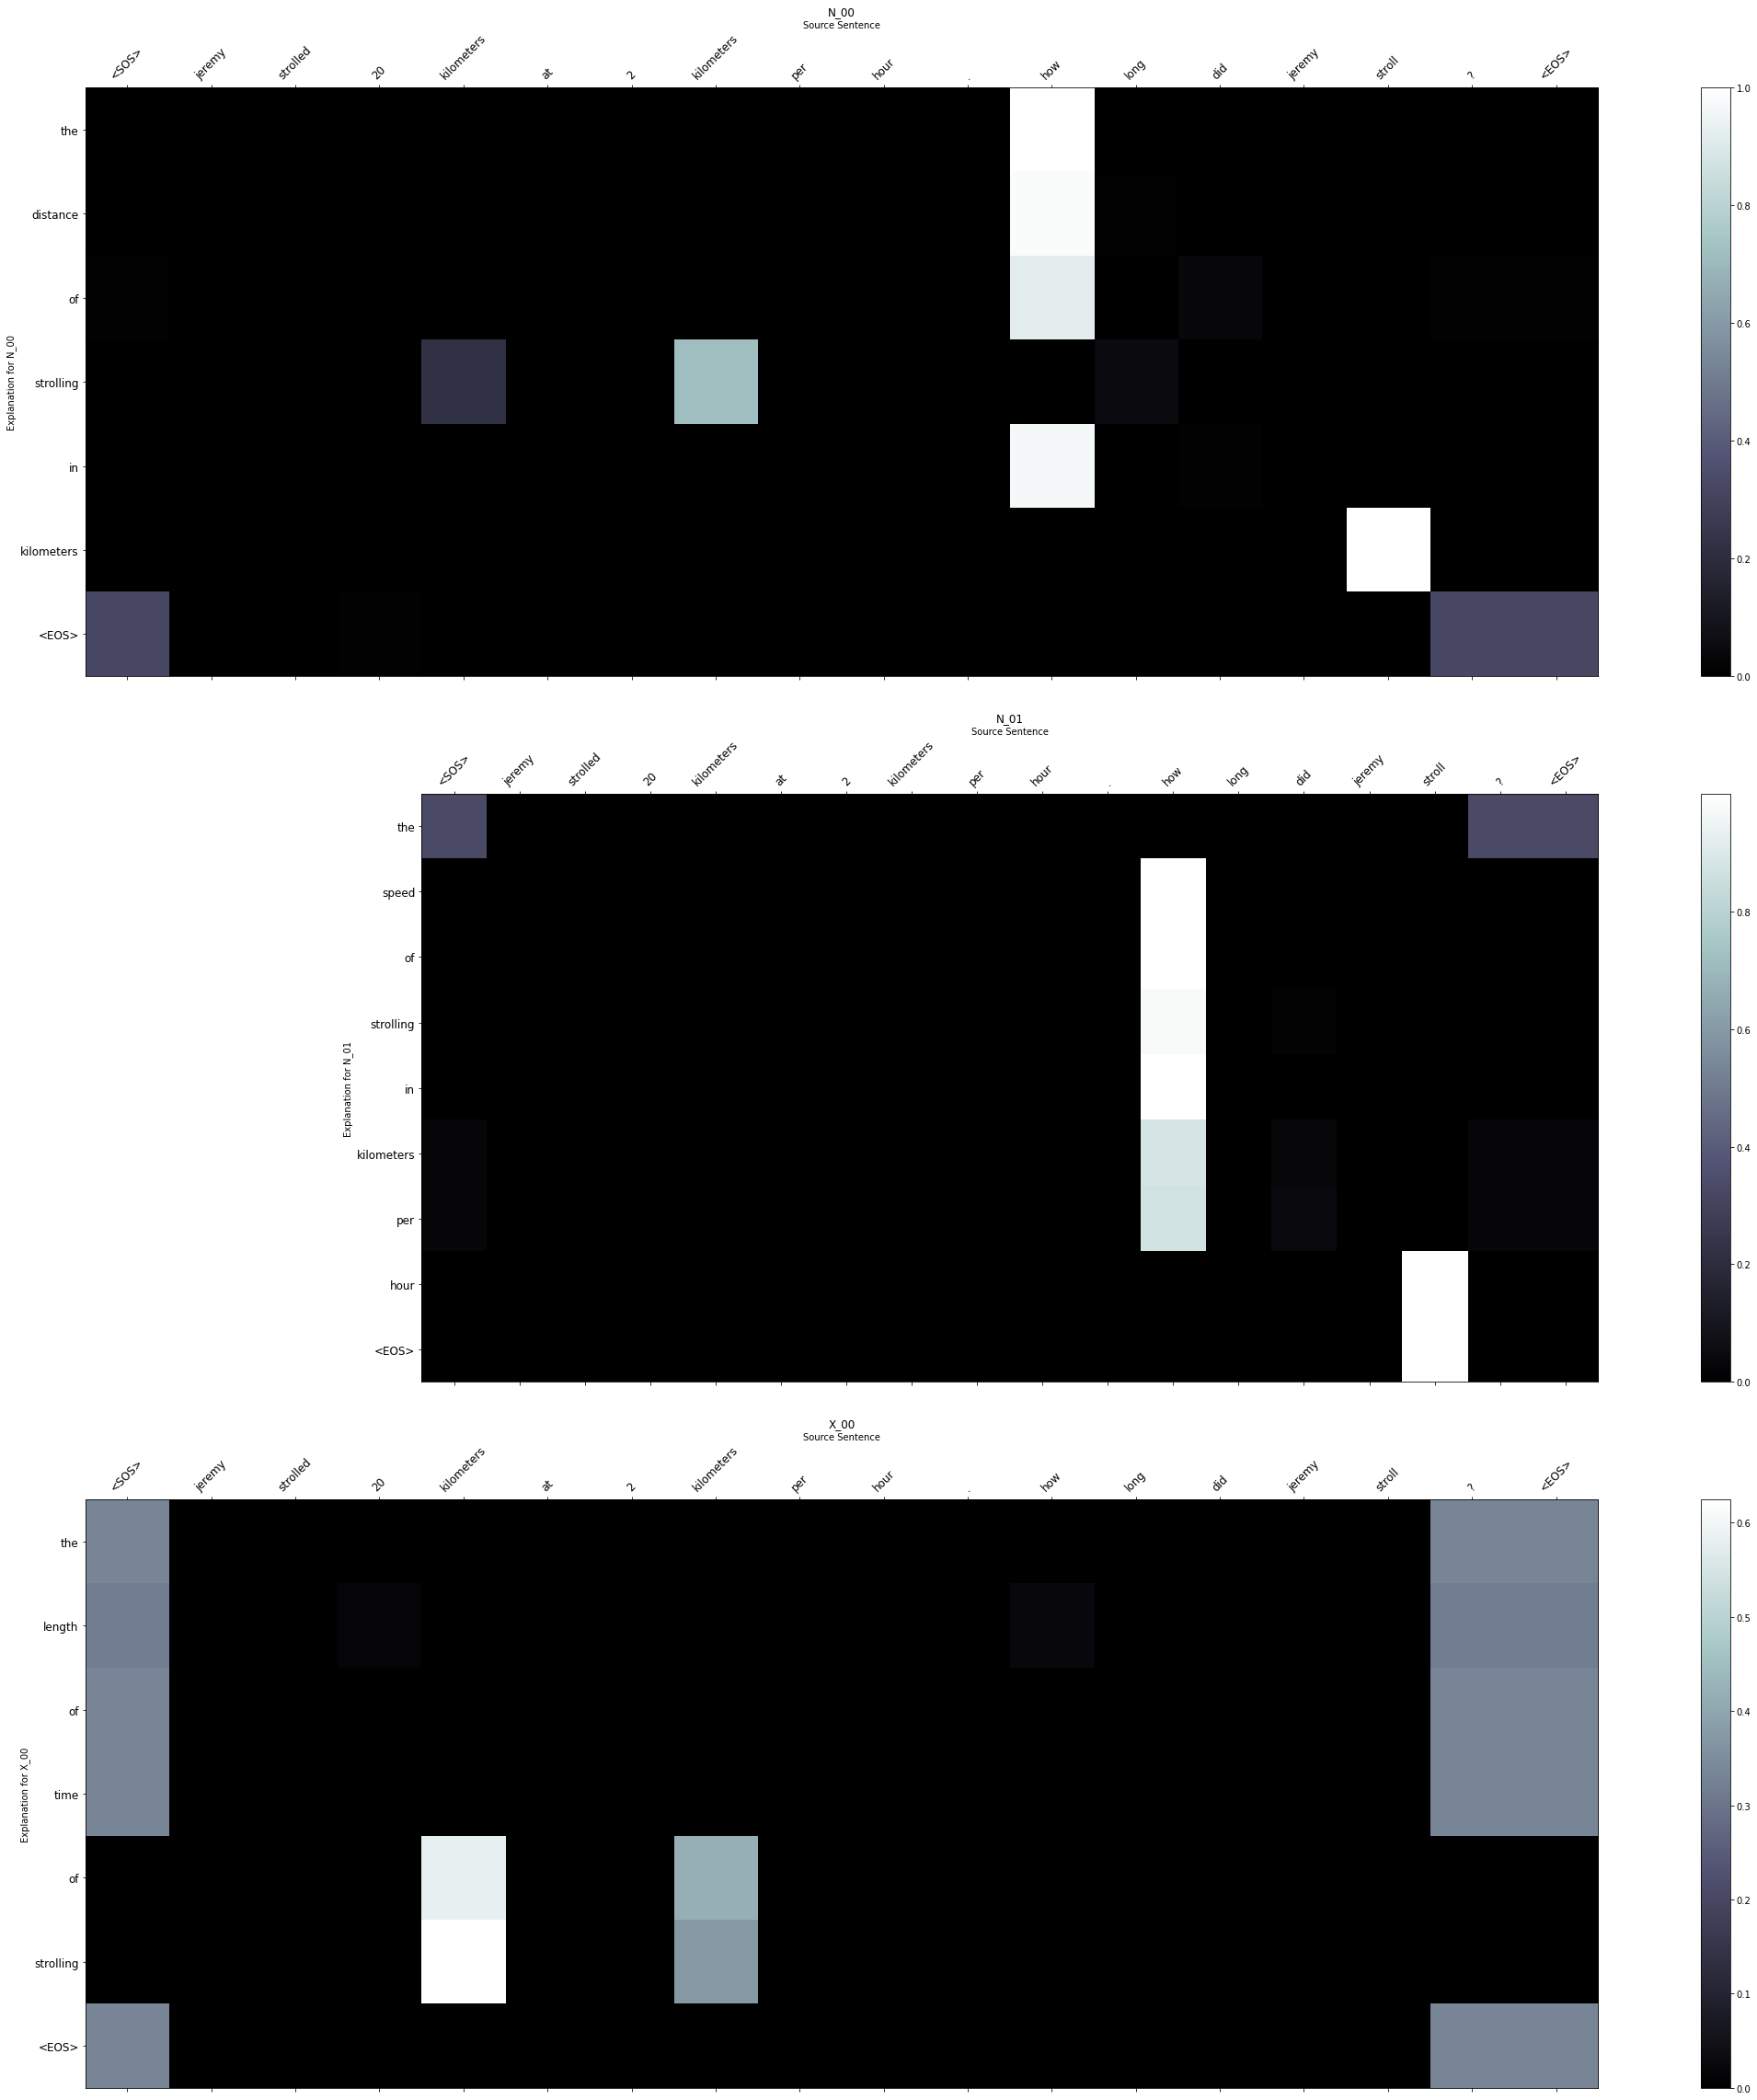

In [17]:
explanations = output['explanation'][0].to_human_readable(tokenizer=tokenizer)

display_attention(
    sentence=batch[PROB_IDX].text.raw[0].split(),
    explanation=explanations,
    attention=nvix.attention_scores
)

In [61]:
explanations['N_00'][0]

'the distance of strolling in kilometers'

In [32]:
import numpy
import matplotlib.pyplot as plt

# http://stackoverflow.com/questions/14391959/heatmap-in-matplotlib-with-pcolor
def plot_head_map(mma, target_labels, source_labels):
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(mma, cmap=plt.cm.Blues)
    # put the major ticks at the middle of each cell
    ax.set_xticks(numpy.arange(mma.shape[1]) + 0.5, minor=False) # mma.shape[1] = target seq 길이
    ax.set_yticks(numpy.arange(mma.shape[0]) + 0.5, minor=False) # mma.shape[0] = input seq 길이
 
    # without this I get some extra columns rows
    # http://stackoverflow.com/questions/31601351/why-does-this-matplotlib-heatmap-have-an-extra-blank-column
    ax.set_xlim(0, int(mma.shape[1]))
    ax.set_ylim(0, int(mma.shape[0]))
 
    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()
 
    # source words -> column labels
    ax.set_xticklabels(source_labels, minor=False)
    # target words -> row labels
    ax.set_yticklabels(target_labels, minor=False)
 
    plt.xticks(rotation=45)
 
    # plt.tight_layout()
    plt.show()

    
def read_plot_alignment_matrices(source_labels, target_labels, alpha):

    mma = alpha.cpu().data.numpy()

    plot_head_map(mma, target_labels, source_labels)

In [33]:
attn = state_dict['explanation.encoder.layer.11.output.LayerNorm.weight']
attn.shape
head_view(attn, encoded_input)

NameError: name 'encoded_input' is not defined

In [ ]:
input_str = "the sears tower in chicago is 145 ##0 feet tall . the john hancock center in chicago is 112 ##7 feet tall . suppose you are asked to build a small - scale replica of each . if you make the sears tower 3 meter tall , what would be the approximate height of the john hancock replica ? round your answer to the nearest hundred ##th ."
encoded_input = tokenizer.encode(input_str)
len(encoded_input)

76

In [ ]:
output_str = "the height of the sears tower"
encoded_output = tokenizer.encode(output_str)
len(encoded_output)

8

In [27]:
config

{'seed': 1,
 'batch_size': 16,
 'beam_for_equation': 3,
 'beam_for_explanation': 5,
 'dataset': '/home/bydelta/SimpleFESTA/resource/dataset/pen.json',
 'learner': {'model': 'SWAN_P1',
  'encoder': 'google/electra-base-discriminator',
  'equation': {'hidden_dim': 0, 'intermediate_dim': 0, 'layer': 6, 'head': 0},
  'explanation': {'encoder': 'google/electra-base-discriminator',
   'shuffle': True}},
 'resource': {'num_gpus': 1.0, 'num_cpus': 1.0},
 'experiment': {'dev': {'split_file': '/home/bydelta/SimpleFESTA/resource/experiments/pen/dev',
   'period': 100},
  'train': {'split_file': '/home/bydelta/SimpleFESTA/resource/experiments/pen/train'},
  'test': {'split_file': '/home/bydelta/SimpleFESTA/resource/experiments/pen/test',
   'period': 500}},
 'grad_clip': 10.0,
 'optimizer': {'type': 'lamb',
  'lr': 0.00176,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'debias': True},
 'scheduler': {'type': 'warmup-linear',
  'num_warmup_epochs': 10.0,
  'num_total_epochs': 500},
 'window': 3}

In [7]:
dataset_file = data_path / 'dataset' / 'pen.json'

KEY_DATASET = 'dataset'
KEY_SEED = 'seed'

exp_base = {
        KEY_DATASET: str(dataset_file.absolute()),
        KEY_SEED: config['seed']
    }

In [ ]:
test_check, test_results = run_model_for_attention(chpt_path, **exp_base)

In [ ]:
test_results